In [1]:
import psycopg2
import sys
from sqlalchemy import create_engine
import geopandas as gpd

In [2]:
# Database name that will be created in the lab session
DATABASE_NAME = "lab_postgis1"

In [4]:
## Function to return the string query for creating sqlalchemy engine of a database
def getEngineConnectionString(user='postgres', password='12345', dbname='postgres'):
    return "postgresql://" + user + ":" + password + "@localhost/" + dbname

In [5]:
## Function to return psycopg2 connection to a database
def getOpenConnection(user='postgres', password='12345', dbname='postgres'):
    return psycopg2.connect(database = dbname, user = user, host='localhost', password= password)

In [6]:
## Creates a database with a given name if it does not exist
def createDB(dbname='postgres'):
    """
    We create a DB by connecting to the default user and database of Postgres
    The function first checks if an existing database exists for a given name, else creates it.
    :return:None
    """
    # Connect to the default database
    con = getOpenConnection(dbname='postgres')
    con.set_isolation_level(psycopg2.extensions.ISOLATION_LEVEL_AUTOCOMMIT)
    cur = con.cursor()

    # Check if an existing database with the same name exists
    cur.execute('SELECT COUNT(*) FROM pg_catalog.pg_database WHERE datname=\'%s\'' % (dbname,))
    count = cur.fetchone()[0]
    if count == 0:
        cur.execute('CREATE DATABASE %s' % (dbname,))  # Create the database
        print("DATABASE " + dbname + " created")
    else:
        print("Database with the given name already exists")

    # Clean up
    cur.close()
    con.commit()
    con.close()

In [7]:
## Create a database with name lab_postgis1
createDB(DATABASE_NAME)

DATABASE lab_postgis1 created


In [8]:
## Create sqlalchemy engine for the created database which will used to load geopandas dataframe to the database
engine = create_engine(getEngineConnectionString(dbname = DATABASE_NAME))
con = engine.connect()
print("sqlalchemy engine created")

sqlalchemy engine created


In [9]:
## In order to work with spatial data in a postgresql database, we need to add postgis extension to the database
try:
    con.execute("CREATE EXTENSION postgis;") # Add PostGIS extension
    print("postgis extension created")
except Exception as e:
    print(e)

postgis extension created


In [10]:
## Load the airbnb shape file to a geopandas dataframe
gdf = gpd.read_file("inputs/airbnb/airbnb_Chicago 2015.shp")

In [11]:
## Display the first 5 rows the geopandas dataframe
gdf.head()

,community,shape_area,shape_len,AREAID,response_r,accept_r,rev_rating,price_pp,room_type,num_spots,...,crowded,dependency,without_hs,unemployed,income_pc,harship_in,num_crimes,num_theft,population,geometry
0,DOUGLAS,46004621.1581,31027.0545098,35,98.771429,94.514286,87.777778,78.157895,1.789474,38,...,1.8,30.7,14.3,18.2,23791,47,5013,1241,18238,"POLYGON ((-87.60914 41.84469, -87.60915 41.844..."
1,OAKLAND,16913961.0408,19565.5061533,36,99.200000,90.105263,88.812500,53.775000,1.850000,20,...,1.3,40.4,18.4,28.7,19252,78,1306,311,5918,"POLYGON ((-87.59215 41.81693, -87.59231 41.816..."
2,FULLER PARK,19916704.8692,None,37,68.000000,NaN,91.750000,84.000000,1.833333,6,...,3.2,44.9,26.6,33.9,10432,97,1764,383,2876,"POLYGON ((-87.62880 41.80189, -87.62879 41.801..."
3,GRAND BOULEVARD,48492503.1554,28196.8371573,38,94.037037,83.615385,92.750000,119.533333,1.533333,30,...,3.3,39.5,15.9,24.3,23472,57,6416,1428,21929,"POLYGON ((-87.60671 41.81681, -87.60670 41.816..."
4,KENWOOD,29071741.9283,23325.1679062,39,92.542857,88.142857,90.656250,77.991453,1.615385,39,...,2.4,35.4,11.3,15.7,35911,26,2713,654,17841,"POLYGON ((-87.59215 41.81693, -87.59215 41.816..."


In [12]:
## load the airbnb data from geopandas dataframe into the database, it will create a table named airbnb. Ignore the warnings
gdf.to_postgis(name = "airbnb", con=engine)

c:\users\kanch\appdata\local\programs\python\python37\lib\site-packages\geopandas\geodataframe.py:830: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


In [13]:
## Load the grocery shape file to a geopandas dataframe and display first 5 rows
gdf_grocery = gpd.read_file("inputs/grocery/chicago_sup.shp")
gdf_grocery.head()

,OBJECTID,Ycoord,Xcoord,Status,Address,Chain,Category,geometry
0,16,41.973266,-87.657073,OPEN,"1051 W ARGYLE ST, CHICAGO, IL. 60640",VIET HOA PLAZA,None,MULTIPOINT (1168268.672 1933554.350)
1,18,41.696367,-87.681315,OPEN,"10800 S WESTERN AVE, CHICAGO, IL. 60643-3226",COUNTY FAIR FOODS,None,MULTIPOINT (1162302.618 1832900.224)
2,22,41.868634,-87.638638,OPEN,"1101 S CANAL ST, CHICAGO, IL. 60607-4932",WHOLE FOODS MARKET,None,MULTIPOINT (1173317.042 1895425.426)
3,23,41.877590,-87.654953,OPEN,"1101 W JACKSON BLVD, CHICAGO, IL. 60607-2905",TARGET/SUPER,new,MULTIPOINT (1168996.475 1898801.406)
4,27,41.737696,-87.625795,OPEN,"112 W 87TH ST, CHICAGO, IL. 60620-1318",FOOD 4 LESS,None,MULTIPOINT (1176991.989 1847262.423)


In [19]:
## load the grocery data from geopandas dataframe into the database, it will create a table named airbnb. Ignore the warnings
gdf_grocery.to_postgis(name = "grocery", con=engine)

c:\users\kanch\appdata\local\programs\python\python37\lib\site-packages\geopandas\geodataframe.py:830: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


In [20]:
## Close the sqlalchemy connection object, because we will work with psycopg2 connection from now on.
if con:
    con.close()

In [21]:
## Get psycopg2 connection to the database
con = getOpenConnection(dbname = DATABASE_NAME)
print("Got psycopg2 connection to the created database")

Got psycopg2 connection to the created database


In [22]:
## Get the cursor for the database connection to execute queries
cur = con.cursor()

In [23]:
## Find the SRID of the airbnb geometries
cur.execute("select ST_SRID(geometry) from airbnb limit 1")
result = cur.fetchall()
print(result)

[(4326,)]


In [24]:
## Find the SRID of the grocery geometries
cur.execute("select ST_SRID(geometry) from grocery limit 1")
result = cur.fetchall()
print(result)

[(6312,)]


In [25]:
## Geometry SRIDs of two tables are different. So, transform one of them and store in a table
cur.execute("create table grocery_new as select ST_Transform(grocery.geometry, 4326) as geometry from grocery")

In [26]:
## Check how new geometry coordinates look like after the transformation
cur.execute("select ST_AsText(geometry) from grocery_new limit 3")
result = cur.fetchall()
print(result)

[('MULTIPOINT(46.06287193273509 48.290595542702505)',), ('MULTIPOINT(45.76229352543728 47.41709723022278)',), ('MULTIPOINT(46.04280440417514 47.94890669715197)',)]


In [27]:
## For each airbnb, find number of groceries that are within the distance 133.9 from the corresponsding airbnb
cur.execute("create table airbnb_grocery as select airbnb.geometry as geom1, count(grocery_new.geometry) as grocery_count from airbnb, grocery_new where ST_Distance(grocery_new.geometry, airbnb.geometry) < 133.9 group by airbnb.geometry")

In [28]:
## Check how the first row of the new joined table looks like
cur.execute("select ST_asText(geom1), grocery_count from airbnb_grocery limit 1")
results = cur.fetchall()
print(results)

[('POLYGON((-87.60948580285748 41.889399110841666,-87.6094855311777 41.889389993870886,-87.60769030638752 41.8893716381027,-87.6076869968646 41.889371973940634,-87.60767568917728 41.889371655505265,-87.607664845606 41.889369172054316,-87.60765523731554 41.88936469338981,-87.60764748452483 41.88935855164218,-87.60764209693983 41.889351108430226,-87.60763665675566 41.8892833191114,-87.60763902935199 41.889278119505484,-87.60764251827996 41.8892734840342,-87.60764525737146 41.88926984464763,-87.60765385666915 41.88926284630008,-87.6076643840481 41.889257506129276,-87.60770687820876 41.88925722635245,-87.6076855608976 41.88923863363624,-87.60767134899436 41.88922623867054,-87.60765313394901 41.88867447671115,-87.60756571760518 41.88867524150202,-87.6075140359486 41.88864033801672,-87.6059100962502 41.88866446462613,-87.60566893920873 41.888665817395164,-87.60546364434137 41.88867203637837,-87.60544897336636 41.888672404144884,-87.60543833345517 41.888672670951486,-87.60543347350675 41.8887

In [29]:
## Commit the created table, otherwise sqlalchemy engine will not find it
con.commit()

In [30]:
## Export the data of the created table to a geopandas dataframe so that we can visualize it
join_sql = "select geom1, grocery_count from airbnb_grocery"
dfJoined = gpd.read_postgis(join_sql, engine, geom_col = "geom1")

In [31]:
## Check first 5 rows of the dataframe
dfJoined.head()

,geom1,grocery_count
0,"POLYGON ((-87.60949 41.88940, -87.60949 41.889...",147
1,"POLYGON ((-87.69646 41.70714, -87.69644 41.706...",116
2,"POLYGON ((-87.54568 41.72282, -87.54600 41.722...",148
3,"POLYGON ((-87.60671 41.81681, -87.60670 41.816...",146
4,"POLYGON ((-87.68465 42.01948, -87.68464 42.019...",131


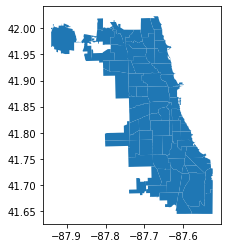

In [32]:
## Plot the geopandas dataframe without any attribute
dfJoined.plot()

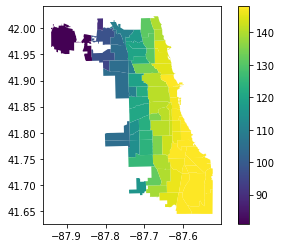

In [33]:
## Show color in airbnb zones based on the number of grocery shops
dfJoined.plot(column = "grocery_count", legend = True)

In [34]:
## Next goal is to plot a categorical map. Divide the number groceries into some ranges

## get the minimum and maximum values of grocery counts
cur.execute("select max(grocery_count) as max_count, min(grocery_count) as min_count from airbnb_grocery")
result = cur.fetchone()
max_count = result[0]
min_count = result[1]
print(max_count, min_count)

148 81


In [35]:
## Find the length of each interval if there are 5 interval/ranges
import math
interval_length = math.ceil((max_count - min_count + 1)/5)
print(interval_length)

14


In [36]:
## Assign a range number to each airbnb zone based on number of grocery shops in its neighborhood
cur.execute("create table airbnb_category as select geom1, cast((grocery_count - {0})/{1} as int) as ranges from airbnb_grocery".format(min_count, interval_length))

In [38]:
## Commit the newly created table
con.commit()

In [39]:
## Export the new table data into geopandas dataframe
join_sql = "select geom1, ranges from airbnb_category"
dfRanges = gpd.read_postgis(join_sql, engine, geom_col = "geom1")

In [40]:
## Check first five rows of the dataframe
dfRanges.head()

,geom1,ranges
0,"POLYGON ((-87.60949 41.88940, -87.60949 41.889...",4
1,"POLYGON ((-87.69646 41.70714, -87.69644 41.706...",2
2,"POLYGON ((-87.54568 41.72282, -87.54600 41.722...",4
3,"POLYGON ((-87.60671 41.81681, -87.60670 41.816...",4
4,"POLYGON ((-87.68465 42.01948, -87.68464 42.019...",3


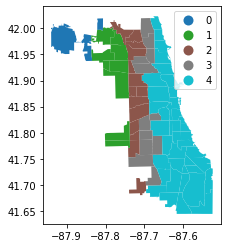

In [41]:
## Plot the airbnb zones where each color represents a range of grocery counts
dfRanges.plot(column = "ranges", categorical = True, legend = True)